In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
# Loading in hourly rain data from CSV, parsing the timestamp, and adding it as an index so it's more useful

rain_df = pd.read_csv('data/ohare_hourly_observations.csv')
rain_df['datetime'] = pd.to_datetime(rain_df['datetime'])
rain_df = rain_df.set_index(pd.DatetimeIndex(rain_df['datetime']))
print(rain_df.dtypes)
rain_df.head()

Unnamed: 0                          int64
datetime                   datetime64[ns]
dewpoint_fahrenheit               float64
drybulb_fahrenheit                float64
hourly_precip                     float64
id                                  int64
latitude                          float64
longitude                         float64
old_station_type                   object
relative_humidity                 float64
report_type                        object
sealevel_pressure                 float64
sky_condition                      object
sky_condition_top                  object
station_pressure                  float64
station_type                      float64
visibility                        float64
wban_code                           int64
weather_types                      object
wetbulb_fahrenheit                float64
wind_direction                     object
wind_direction_cardinal            object
wind_speed                        float64
call_sign                         

C:\Python35\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,datetime,dewpoint_fahrenheit,drybulb_fahrenheit,hourly_precip,id,latitude,longitude,old_station_type,relative_humidity,...,station_pressure,station_type,visibility,wban_code,weather_types,wetbulb_fahrenheit,wind_direction,wind_direction_cardinal,wind_speed,call_sign
2016-08-16 22:51:00,0,2016-08-16 22:51:00,65.0,74.0,0.0,398063571,NaN,NaN,NaN,74.0,...,29.37,11.0,10.0,94846,NaN,68.0,200,SSW,7.0,KORD
2016-08-16 21:51:00,1,2016-08-16 21:51:00,64.0,74.0,0.0,397933331,NaN,NaN,NaN,71.0,...,29.36,11.0,10.0,94846,NaN,68.0,200,SSW,5.0,KORD
2016-08-16 20:51:00,2,2016-08-16 20:51:00,64.0,76.0,0.0,397986035,NaN,NaN,NaN,67.0,...,29.35,11.0,10.0,94846,NaN,68.0,220,SW,3.0,KORD
2016-08-16 19:51:00,3,2016-08-16 19:51:00,64.0,78.0,0.0,398003060,NaN,NaN,NaN,62.0,...,29.34,11.0,10.0,94846,NaN,69.0,NaN,NaN,0.0,KORD
2016-08-16 18:51:00,4,2016-08-16 18:51:00,65.0,76.0,0.0,397972638,NaN,NaN,NaN,69.0,...,29.32,11.0,10.0,94846,NaN,69.0,160,SSE,6.0,KORD


In [4]:
# Resampling the dataframe into one hour increments, accessing max because accumulation listed more often than hourly (i.e. 
# every 15 minutes) is the total precipitation since the hour began
# Description: http://www1.ncdc.noaa.gov/pub/data/cdo/documentation/LCD_documentation.pdf

chi_rain_series = rain_df['hourly_precip'].resample('1H').max()
print(chi_rain_series.count())
chi_rain_series.head()

150104


1996-08-01 00:00:00    0.0
1996-08-01 01:00:00    0.0
1996-08-01 02:00:00    0.0
1996-08-01 03:00:00    0.0
1996-08-01 04:00:00    0.0
Freq: H, Name: hourly_precip, dtype: float64

### N-Year Metrics

Using rolling time series in pandas to find n-year events. First looking at some for 6 hour interval.

The rolling sum here calculates the sum of observations over a given number of observations over time. Since each observation here is an hour, the window we provide is a number of hours. Each row is then the sum of observations over that number of hours.

If we had the following rows:

* 1pm: 2
* 2pm: 3
* 3pm: 1
* 4pm: 5

And we calculate the rolling sum with a window of 2 hours, the results will be:

* 1pm: NaN (because we only have one observation at this point)
* 2pm: 5
* 3pm: 4
* 4pm: 6

Details of the specific cutoffs for each level of n-year storm can be found here: [Rainfall Frequency Information Illinois](http://www.isws.illinois.edu/atmos/statecli/RF/rf.htm)

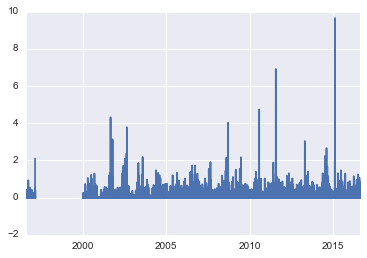

In [5]:
roll_6_hr = chi_rain_series.rolling(window=6)
roll_6_hr.sum().plot()

##### Notes on Initial Results 

Because it's looking for a count of intervals, the initial counts of events returned could include more than one event per storm. For example, if one storm lasted 8 hours from 1pm to 9pm and rained relatively consistently throughout at a 5-year event level and we're looking for 6 hour intervals, it could count for as many as 3 events.

In [6]:
roll_6 = pd.DataFrame(roll_6_hr.sum())

print('For 6-hour intervals')
print('{} 1-year events for Northeast Illinois'.format(len(roll_6[(roll_6['hourly_precip'] >= 1.88) & 
                                                                  (roll_6['hourly_precip'] < 2.28)])))
print('{} 2-year events for Northeast Illinois'.format(len(roll_6[(roll_6['hourly_precip'] >= 2.28) &
                                                                  (roll_6['hourly_precip'] < 2.85)])))
print('{} 5-year events for Northeast Illinois'.format(len(roll_6[(roll_6['hourly_precip'] >= 2.85) &
                                                                  (roll_6['hourly_precip'] < 3.35)])))
print('{} 10-year events for Northeast Illinois'.format(len(roll_6[(roll_6['hourly_precip'] >= 3.35) &
                                                                   (roll_6['hourly_precip'] < 4.13)])))
print('{} 25-year events for Northeast Illinois'.format(len(roll_6[(roll_6['hourly_precip'] >= 4.13) & 
                                                                   (roll_6['hourly_precip'] < 4.90)])))
print('{} 50-year events for Northeast Illinois'.format(len(roll_6[(roll_6['hourly_precip'] >= 4.90) &
                                                                   (roll_6['hourly_precip'] < 5.69)])))
print('{} 100-year events for Northeast Illinois'.format(len(roll_6[roll_6['hourly_precip'] >= 5.69])))

For 6-hour intervals
39 1-year events for Northeast Illinois
19 2-year events for Northeast Illinois
13 5-year events for Northeast Illinois
8 10-year events for Northeast Illinois
9 25-year events for Northeast Illinois
2 50-year events for Northeast Illinois
9 100-year events for Northeast Illinois


In [7]:
roll_6_1yr = roll_6[(roll_6['hourly_precip'] >= 1.88) & (roll_6['hourly_precip'] < 2.28)]
print('{} days with 1-year events in Northeast Illinois'.format(len(roll_6_1yr.groupby(roll_6_1yr.index.date))))
roll_6_1yr

18 days with 1-year events in Northeast Illinois


,hourly_precip
1997-02-21 04:00:00,1.910
1997-02-21 05:00:00,2.100
2001-08-30 20:00:00,2.130
2001-08-31 02:00:00,2.190
2001-10-13 20:00:00,1.970
2002-07-09 01:00:00,2.080
2002-07-09 02:00:00,2.085
2002-07-09 03:00:00,2.085
2002-07-09 04:00:00,2.085
2002-07-09 05:00:00,2.085


In [8]:
# Many of these are from the same days, but over slightly different intervals as mentioned before
roll_6_2yr = roll_6[(roll_6['hourly_precip'] >= 2.28) & (roll_6['hourly_precip'] < 2.85)]
print('{} days with 2-year events in Northeast Illinois'.format(len(roll_6_2yr.groupby(roll_6_2yr.index.date))))
roll_6_2yr

11 days with 2-year events in Northeast Illinois


,hourly_precip
2001-10-13 15:00:00,2.740
2001-10-13 19:00:00,2.540
2002-08-13 18:00:00,2.365
2002-08-22 07:00:00,2.410
2008-09-13 04:00:00,2.490
2008-09-13 11:00:00,2.720
2010-07-23 23:00:00,2.535
2010-07-24 06:00:00,2.730
2010-07-24 07:00:00,2.550
2011-07-23 00:00:00,2.630


In [9]:
# Helper function taking the series, window, and list of cutoffs to make this quicker, returns the subset
def rolling_results(rain_series, window, rain_cutoffs):
    window_df = pd.DataFrame(rain_series.rolling(window=window).sum())
    print('For {}-hour intervals'.format(window))
    print('{} 1-year events for Northeast Illinois'.format(len(window_df[(window_df['hourly_precip'] >= rain_cutoffs[0]) & 
                                                                         (window_df['hourly_precip'] < rain_cutoffs[1])])))
    print('{} 2-year events for Northeast Illinois'.format(len(window_df[(window_df['hourly_precip'] >= rain_cutoffs[1]) & 
                                                                         (window_df['hourly_precip'] < rain_cutoffs[2])])))
    print('{} 5-year events for Northeast Illinois'.format(len(window_df[(window_df['hourly_precip'] >= rain_cutoffs[2]) & 
                                                                         (window_df['hourly_precip'] < rain_cutoffs[3])])))
    print('{} 10-year events for Northeast Illinois'.format(len(window_df[(window_df['hourly_precip'] >= rain_cutoffs[3]) & 
                                                                         (window_df['hourly_precip'] < rain_cutoffs[4])])))
    print('{} 25-year events for Northeast Illinois'.format(len(window_df[(window_df['hourly_precip'] >= rain_cutoffs[4]) & 
                                                                          (window_df['hourly_precip'] < rain_cutoffs[5])])))
    print('{} 50-year events for Northeast Illinois'.format(len(window_df[(window_df['hourly_precip'] >= rain_cutoffs[5]) & 
                                                                          (window_df['hourly_precip'] < rain_cutoffs[6])])))
    print('{} 100-year events for Northeast Illinois'.format(len(window_df[window_df['hourly_precip'] >= rain_cutoffs[6]])))
    
# Gets the subset of the dataframe for the given cutoff index (i.e. 5 year is the third, so cutoff_index would be 3)
def rolling_subset(rain_series, window, rain_cutoffs, cutoff_index):
    window_df = pd.DataFrame(rain_series.rolling(window=window).sum())
    if cutoff_index <= 6:
        return window_df[(window_df['hourly_precip'] >= rain_cutoffs[cutoff_index - 1]) & (roll_6['hourly_precip'] < 2.85)]
    if cutoff_index == 7:
        return window_df[window_df['hourly_precip'] >= rain_cutoffs[cutoff_index -1]]

In [10]:
cutoffs_12hr = [2.18, 2.64, 3.31, 3.89, 4.79, 5.6, 6.59]
rolling_results(chi_rain_series, 12, cutoffs_12hr)

For 12-hour intervals
58 1-year events for Northeast Illinois
24 2-year events for Northeast Illinois
28 5-year events for Northeast Illinois
25 10-year events for Northeast Illinois
7 25-year events for Northeast Illinois
11 50-year events for Northeast Illinois
21 100-year events for Northeast Illinois


In [11]:
roll_12_2yr = rolling_subset(chi_rain_series, 12, cutoffs_12hr, 2)
print('{} days with 2-year events for 12 hrs in Northeast Illinois'.format(len(roll_12_2yr.groupby(roll_12_2yr.index.date))))

14 days with 2-year events for 12 hrs in Northeast Illinois


In [12]:
cutoffs_24hr = [2.51, 3.04, 3.80, 4.47, 5.51, 6.46, 7.58]
rolling_results(chi_rain_series, 24, cutoffs_24hr)

For 24-hour intervals
87 1-year events for Northeast Illinois
52 2-year events for Northeast Illinois
62 5-year events for Northeast Illinois
20 10-year events for Northeast Illinois
24 25-year events for Northeast Illinois
29 50-year events for Northeast Illinois
30 100-year events for Northeast Illinois


In [13]:
roll_24_1yr = rolling_subset(chi_rain_series, 24, cutoffs_24hr, 1)
print('{} days with 1-year events for 24 hrs in Northeast Illinois'.format(len(roll_24_1yr.groupby(roll_24_1yr.index.date))))

33 days with 1-year events for 24 hrs in Northeast Illinois


In [14]:
cutoffs_48hr = [2.70, 3.30, 4.09, 4.81, 5.88, 6.84, 8.16]
rolling_results(chi_rain_series, 48, cutoffs_48hr)

For 48-hour intervals
199 1-year events for Northeast Illinois
114 2-year events for Northeast Illinois
123 5-year events for Northeast Illinois
43 10-year events for Northeast Illinois
47 25-year events for Northeast Illinois
41 50-year events for Northeast Illinois
90 100-year events for Northeast Illinois


In [15]:
roll_48_1yr = rolling_subset(chi_rain_series, 48, cutoffs_48hr, 1)
print('{} days with 1-year events for 48 hrs in Northeast Illinois'.format(len(roll_48_1yr.groupby(roll_48_1yr.index.date))))

50 days with 1-year events for 48 hrs in Northeast Illinois


**Note:** Because the rolling window pulls from the same overlapping period multiple times, it makes sense that longer time periods have higher amounts of events at the lower end of the spectrum. They're pulling from the same incidents more times than the shorter intervals can